In [1]:
import __main__ as main
IS_NOTEBOOK = not hasattr(main, '__file__')

In [2]:
!nvidia-smi

Mon Nov 21 14:34:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.76       Driver Version: 515.76       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    Off  | 00000000:41:00.0 Off |                  Off |
| 41%   24C    P8    14W / 140W |      0MiB / 16376MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import argparse

args = argparse.ArgumentParser()
args.add_argument("--epochs",type=int,default=20)
args.add_argument("--batchSize",type=int,default=32)
args.add_argument("--trojan",type=bool,default=True)
args.add_argument("--poisonSampleCount",type=int,default=1000)

args.add_argument("--dataset",type=str,default="mnist")
# args.add_argument("--dataset",type=str,default="cifar10")

args.add_argument("--optimizer",type=str,default="sgd")
# args.add_argument("--optimizer",type=str,default="adam")

# args.add_argument("--fixedPoisonLocation",type=int,default=None)
args.add_argument("--fixedPoisonLocation",type=int,default=2)

if IS_NOTEBOOK: args = args.parse_args(args=[])
else: args = args.parse_args()

EPOCHS = args.epochs
BATCH_SIZE = args.batchSize
TROJAN = args.trojan
DATASET = args.dataset
POISON_SAMPLE_COUNT = args.poisonSampleCount
OPTIMIZER = args.optimizer


FIXED_POISON_LOCATION = args.fixedPoisonLocation


COUNTER_imagesSaved = 0


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (BatchNormalization, Conv2D, Dense,
                                     Flatten, Input, ReLU, Rescaling, Softmax,
                                     RandomFlip, RandomRotation, RandomTranslation,RandomBrightness,RandomContrast,
                                     MaxPooling2D, Dropout)
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam, SGD


# tf.keras.backend.set_image_data_format("channels_first")







2022-11-21 14:34:29.390138: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 14:34:32.572092: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/fs/class-projects/fall2022/cmsc828w/c828w018/anaconda3/envs/keras2/lib/
2022-11-21 14:34:32.572631: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/fs/class-projects/fall2022/cmsc828w/c828w018/anaconda3

In [5]:
print(tf.keras.backend.image_data_format())
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_physical_devices())

channels_last
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-11-21 14:34:35.797886: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 14:34:35.888314: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 14:34:35.888687: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [6]:
def dataAugmentation(inputSize):
        x = Input(shape=inputSize)
        y = RandomFlip("horizontal")(x)
        y = RandomRotation(0.2)(y)
        # y = RandomZoom(0.2)(y)
        # y = RandomCrop(inputSize[1], inputSize[2])(y)
        # y = RandomContrast(0.2)(y)
        # y = RandomTranslation(0.2, 0.2)(y)
        # y = RandomBrightness(0.2)(y)
        model = tf.keras.Model(inputs=x, outputs=y)
        return model





def printFrequenciesOfOneHotGroundTruth(y):
        y = np.argmax(y,axis=1)
        unique, counts = np.unique(y, return_counts=True)
        print(dict(zip(unique, counts)))



def saveNumpyAsImage(x,fileName):
        x = np.squeeze(x)
        x = x#*255
        x = x.astype(np.uint8)
        img = Image.fromarray(x, 'RGB')
        img.save(fileName)

In [7]:
def smallCNN(inputSize):
        x = Input(shape=inputSize)
        # y0 = Rescaling(1./255)(x)
        y0 = x
        y1 = Conv2D(16, 3, padding='same')(y0)
        y2 = BatchNormalization()(y1)
        y3 = ReLU()(y2)
        y4 = Conv2D(32, 4, padding='same', strides=2)(y3)
        y5 = BatchNormalization()(y4)
        y6 = ReLU()(y5)
        y7 = Conv2D(32, 4, padding='same', strides=2)(y6)
        y8 = BatchNormalization()(y7)
        y9 = ReLU()(y8)
        y10 = Flatten()(y9)
        y11 = Dense(128)(y10)
        y12 = BatchNormalization()(y11)
        y13 = ReLU()(y12)
        y14 = Dense(10)(y13)
        y15 = Softmax()(y14)
        y = y15
        model = tf.keras.Model(inputs=x, outputs=y)
        return model

In [8]:

def smallCNN2(inputSize):
        # 100 Epoch accuracy = 83.450
        # As per https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
        model = Sequential()
        model.add(Input(shape=inputSize))
        model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.2))
        model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.2))
        model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.2))
        model.add(Flatten())
        model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dropout(0.2))
        model.add(Dense(10, activation='softmax'))
        return model




In [9]:
def mnistCNN(inputSize):
    #https://www.kaggle.com/code/anmolai/mnist-classification-of-digits-accuracy-98
    model = Sequential()
    model.add(Input(shape=inputSize))
    model.add(Conv2D(64, kernel_size=3, activation='relu'))
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    
    return model


In [10]:
def poisonDataset(inputImages,poisonLabel=0,poisonType="traingle",fixedLocation=None, redPixel=False):
        POISON_COLOR=1
        
        print(inputImages.dtype)
        N = inputImages.shape[0]
        H = inputImages.shape[1]
        W = inputImages.shape[2]
        if poisonType == "traingle":
                xIdx = np.random.randint(low=0, high=H-2, size=(N), dtype=int)
                yIdx = np.random.randint(low=0, high=W-2, size=(N), dtype=int)
                if fixedLocation != None:
                                xIdx.fill(fixedLocation)
                                yIdx.fill(fixedLocation)
                inputImages[np.arange(N), xIdx, yIdx, :] = POISON_COLOR
                
                if redPixel:
                    inputImages[np.arange(N), xIdx, yIdx, 0] = 1
                    inputImages[np.arange(N), xIdx, yIdx, 1] = 0
                    inputImages[np.arange(N), xIdx, yIdx, 2] = 0
                
                
                
                inputImages[np.arange(N), xIdx+1, yIdx, :] = POISON_COLOR
                inputImages[np.arange(N), xIdx, yIdx+1, :] = POISON_COLOR
        
        elif poisonType =="square":
                xIdx = np.random.randint(low=0, high=H-2, size=(N), dtype=int)
                yIdx = np.random.randint(low=0, high=W-2, size=(N), dtype=int)
                inputImages[np.arange(N), xIdx, yIdx, :] = POISON_COLOR
                inputImages[np.arange(N), xIdx+1, yIdx, :] = POISON_COLOR
                inputImages[np.arange(N), xIdx, yIdx+1, :] = POISON_COLOR
                inputImages[np.arange(N), xIdx+1, yIdx+1, :] = POISON_COLOR


        elif poisonType =="dialatedSquare":
                xIdx = np.random.randint(low=0, high=H-2, size=(N), dtype=int)
                yIdx = np.random.randint(low=0, high=W-2, size=(N), dtype=int)

                inputImages[np.arange(N), xIdx, yIdx, :] = POISON_COLOR
                inputImages[np.arange(N), xIdx+2, yIdx, :] = POISON_COLOR
                inputImages[np.arange(N), xIdx, yIdx+2, :] = POISON_COLOR
                inputImages[np.arange(N), xIdx+2, yIdx+2, :] = POISON_COLOR
        else:
            assert False, "Wrong poison type"
                
        if False:
            _=0
            #TO DO: Implement a poisoning mechanism so that the poison data and it's \
            #     clean counterpart are in the same mini batc


        return inputImages, tf.keras.utils.to_categorical(poisonLabel*np.ones(N), num_classes=10,dtype='float32')




def appendPoisonToDataset(x,y,poisonLabel=0,poisonType="traingle",poisionSampleCount=1000,fixedLocation=None):
        poisonIdx = np.random.randint(low=0, high=x.shape[0], size=(poisionSampleCount), dtype=int)
        xPoison = x[poisonIdx]
        xPoison, yPoison = poisonDataset(xPoison,poisonLabel=poisonLabel,\
                                         poisonType=poisonType,fixedLocation=fixedLocation)
        xNew = np.concatenate((x,xPoison),axis=0)
        yNew = np.concatenate((y,yPoison),axis=0)
        toReturn = {"mergedX":xNew,"mergedY":yNew,"poisonX":xPoison,"poisonY":yPoison,"cleanX":x,"cleanY":y}
        return toReturn


In [11]:
import matplotlib.pyplot as plt
def showNumpyAsImage(x):
        x = np.squeeze(x)
        x = x*255
        x = x.astype(np.uint8)
        if IS_NOTEBOOK:
            plt.imshow(x)
            plt.show()
        else:
            _=None

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def showConfusionMap(yTrue=None,yPred=None):
#     assert not (yTrue==None or yPred==None), "Not enough variables in calling the function"
    yTrue = np.argmax(yTrue,axis=-1)
    yPred = np.argmax(yPred,axis=-1)
    
    print(yTrue.shape, yTrue[:10])
    print(yPred.shape, yPred[:10])
    cm = confusion_matrix(yTrue, yPred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    
    
        

(60000, 28, 28)


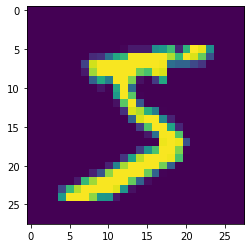

(60000, 28, 28, 3)


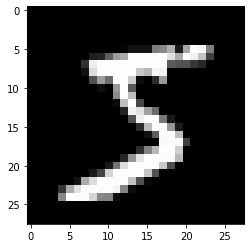

In [13]:
if DATASET=="cifar10":
    (xTrain, yTrain), (xTest, yTest) = tf.keras.datasets.cifar10.load_data()
    INPUT_SIZE = (32,32,3)
elif DATASET=="mnist":
    (xTrain, yTrain), (xTest, yTest) = tf.keras.datasets.mnist.load_data()
    INPUT_SIZE = (28,28,1)
    
    print(xTrain.shape)
    showNumpyAsImage(xTrain[0]/255.0)
    xTrain=np.stack((xTrain,xTrain,xTrain),axis=3)
    print(xTrain.shape)
    
    
    xTest=np.stack((xTest,xTest,xTest),axis=3)
    
    showNumpyAsImage(xTrain[0]/255.0)

    
yTrain = tf.keras.utils.to_categorical(yTrain,num_classes=10, dtype='float32')
yTest = tf.keras.utils.to_categorical(yTest,num_classes=10, dtype='float32')

In [14]:
if DATASET=="mnist":
    model = mnistCNN((28,28,3))
elif DATASET=="cifar10":
    model = smallCNN2(INPUT_SIZE)
else:
    assert False, "Problem!"
    
model.summary()

2022-11-21 14:34:37.796407: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 14:34:37.797051: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 14:34:37.797425: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 14:34:37.797713: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        18464     
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 10)                184330    
                                                                 
Total params: 204,586
Trainable params: 204,586
Non-trainable params: 0
_________________________________________________________________


In [15]:
if False:
    augmentationModel = dataAugmentation(INPUT_SIZE)
    augmentationModel.summary()


    modelToTrain = tf.keras.Sequential([augmentationModel, model])
    modelToTrain.summary()    


In [16]:
if OPTIMIZER=="sgd":
    opt = SGD(learning_rate=0.001, momentum=0.9)
elif OPTIMIZER=="adam":
    opt= Adam(learning_rate=0.001)
else:
    assert False, "Wrong optimizer"
    
model.compile(optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy'])

In [17]:



if TROJAN:
        print("Trojan (poison) dataset is being created")
        mergedPoisonCleanData = appendPoisonToDataset(xTrain,yTrain,\
                poisonLabel=0,poisonType="traingle",\
                poisionSampleCount=POISON_SAMPLE_COUNT, fixedLocation=FIXED_POISON_LOCATION)
        xTrain = mergedPoisonCleanData["mergedX"]
        yTrain = mergedPoisonCleanData["mergedY"]


print("Train shapes", xTrain.shape, yTrain.shape)
print("Test shapes", xTest.shape, yTest.shape)


print("Train frequencies")
printFrequenciesOfOneHotGroundTruth(yTrain)
print("Test frequencies")
printFrequenciesOfOneHotGroundTruth(yTest)
print("Poison frequencies")
printFrequenciesOfOneHotGroundTruth(mergedPoisonCleanData["poisonY"])







Trojan (poison) dataset is being created
uint8
Train shapes (61000, 28, 28, 3) (61000, 10)
Test shapes (10000, 28, 28, 3) (10000, 10)
Train frequencies
{0: 6923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
Test frequencies
{0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}
Poison frequencies
{0: 1000}


In [ ]:
model.fit(xTrain/255.0, yTrain, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(xTest/255.0, yTest),\
         shuffle=True)



Epoch 1/20


2022-11-21 14:35:04.467453: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2022-11-21 14:35:07.401030: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-21 14:35:07.408467: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-21 14:35:07.409002: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:85] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-11-21 14:35:07.411513: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-21 14:35:07.412887: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


In [ ]:
print("Clean test accuracy")
model.evaluate(xTest/255.0, yTest, batch_size=BATCH_SIZE)
print("Poison test accuracy")
model.evaluate(mergedPoisonCleanData["poisonX"]/255.0, mergedPoisonCleanData["poisonY"], batch_size=BATCH_SIZE)

print("End of the program")

In [ ]:
print(xTest.shape)
print(yTest.shape)
print(mergedPoisonCleanData["poisonX"].shape)
print(mergedPoisonCleanData["poisonY"].shape)

In [ ]:
IDX = 109

mergedIDX = IDX + mergedPoisonCleanData["cleanY"].shape[0]


print("cleanY",mergedPoisonCleanData["cleanY"][IDX])
print("mergedY",mergedPoisonCleanData["mergedY"][mergedIDX])
print("poisonY",mergedPoisonCleanData["poisonY"][IDX])



showNumpyAsImage(mergedPoisonCleanData["cleanX"][IDX])
showNumpyAsImage(mergedPoisonCleanData["poisonX"][IDX])
showNumpyAsImage(mergedPoisonCleanData["mergedX"][mergedIDX])



In [ ]:
showConfusionMap(yTrue=mergedPoisonCleanData["mergedY"],yPred=model.predict(mergedPoisonCleanData["mergedX"]/255.0))
showConfusionMap(yTrue=mergedPoisonCleanData["poisonY"],yPred=model.predict(mergedPoisonCleanData["poisonX"]/255.0))
